In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
import equinox as eqx
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random, nn, vmap
from functools import partial
import optax

from models import exact_blr, log_ratio, BayesRegression, SVIRegression, BMRRegression
from networks import MLP

from jax.config import config

rng_key = random.PRNGKey(0)

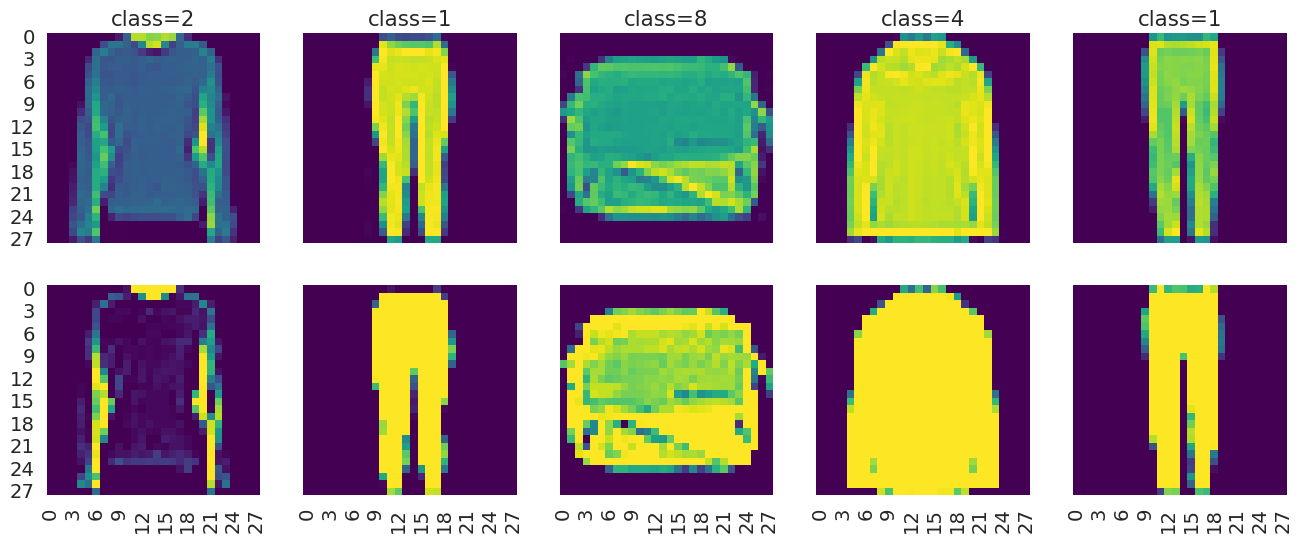

In [4]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')

train_ds['image'] = train_ds['image'].squeeze().reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].squeeze().reshape(test_ds['image'].shape[0], -1)

_, in_size = train_ds['image'].shape
out_size = len(jnp.unique(train_ds['label'])) - 1

# number of neurons in hidden layer
num_hn = [50, 100, 200]

# whitening
n, d = train_ds['image'].shape
mean = train_ds['image'].mean()
std = train_ds['image'].std()

X = (train_ds['image'] - mean) / std 
X_test = (test_ds['image'] - mean) / std
in_size = X.shape[1]

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].reshape(28, 28), cmap='viridis', ax = axes[0, n], cbar=False, vmax=1., vmin=0.)
    axes[0, n].set_title('class={}'.format(train_ds['label'][n]))
    sns.heatmap(X[n].reshape(28, 28), cmap='viridis', ax = axes[1, n], cbar=False, vmax=1., vmin=0.)

In [5]:
import tensorflow_probability.substrates.jax.stats as stats
import tensorflow as tf
from numpyro.infer import log_likelihood
from numpyro.infer import Predictive

def mean_ll(log_like):

    S = log_like.shape[0]
    ll = nn.logsumexp(log_like - jnp.log(S), axis=0) 
    lpd = nn.logsumexp(log_like.sum(-1) - jnp.log(S))

    return ll, lpd 

def test_smpl(rng_key, model, sample, labels):
    pred = Predictive(model, posterior_samples=sample, parallel=True, return_sites=['obs', 'probs'])

    ll = log_likelihood(model, sample, parallel=True, obs=labels)

    ll, lpd = mean_ll(ll['obs'])

    rng_key, _rng_key = random.split(rng_key)
    pred_sample = pred(_rng_key)

    probs = pred_sample['probs'].mean(0)
    pred_labels = probs.argmax(-1)
    logits = jnp.log(probs)

    hit = pred_labels == labels
    acc = hit.mean(-1)

    return {
        'acc': acc,
        'nll': -ll.mean(),
        'lpd': lpd.item(),
    }

def compression(L, samples, cuttoff=1.):
    compressed_smpl = samples.copy()
    nonzero = 0
    count = 0
    for l in range(L):
        mu = samples[f'layer{l}.weight'].mean(0)
        std = samples[f'layer{l}.weight'].std(0)
        z = mu/std
        zeros = jnp.abs(z) > cuttoff
        nonzero += zeros.sum()
        count += z.shape[0] * z.shape[1]
        compressed_smpl[f'layer{l}.weight'] = samples[f'layer{l}.weight'] * zeros
        compressed_smpl[f'layer{l}.weight_base'] = samples[f'layer{l}.weight_base'] * zeros

    return compressed_smpl, 1 - nonzero/count

def compression2(key, L, params, cuttoff=1.):
    compressed_smpl = {}
    nonzero = 0
    count = 0
    for l in range(L):
        mu = params[f'layer{l}.weight.loc'].mean(0)
        std = jnp.sqrt( jnp.square(params[f'layer{l}.weight.scale']) ).mean(0)
        z = mu/std
        zeros = jnp.abs(z) > cuttoff
        nonzero += zeros.sum()
        count += z.shape[0] * z.shape[1]
        compressed_smpl[f'layer{l}.weight_base'] =jnp.where(zeros, mu + std * random.normal(key, (100,) + mu.shape), 0.)
        compressed_smpl[f'layer{l}.weight'] = compressed_smpl[f'layer{l}.weight_base']

    return compressed_smpl, 1 - nonzero/count

depth = 1
out_size = 10
opts = {
    'num_steps': 80_000,
    'batch_size': 512,
    'num_particles': 16,
    'learning_rate': 1e-3,
    'gamma0': 0.2
}

1 200


100%|██████████| 80000/80000 [06:31<00:00, 204.09it/s, init loss: 896585.6250, avg. loss [76001-80000]: 25940.2969]


-3671.85302734375 0.8896 0.31241864
-22149.775390625 0.25509998 2.2980897 0.9977234


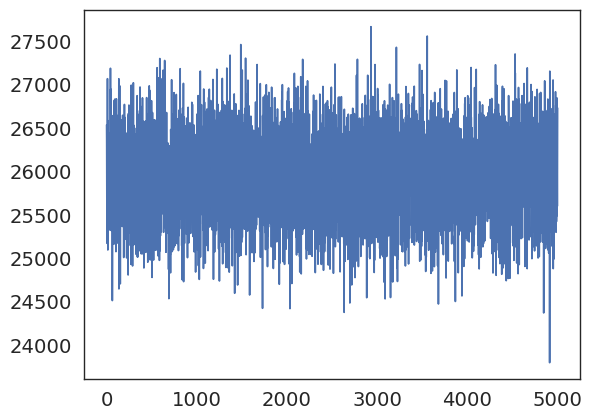

In [6]:
for nh in num_hn[-1:]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        posterior='matrixnormal',
        gamma0=opts['gamma0'],
        tau0=1e-4, 
        reduced=True
    )
    
    bmr_reg.fit(
        train_ds['label'], 
        num_steps=opts['num_steps'], 
        num_particles=opts['num_particles'], 
        progress_bar=True, 
        opt_kwargs={'learning_rate': opts['learning_rate']}
    )
    plt.plot(bmr_reg.results.losses[-5_000:])

    bmr_reg.samples.pop('obs')
    bmr_reg.samples.pop('beta')    
    bmr_reg.set_input(X_test)

    out = test_smpl(_rng_key, bmr_reg.model, bmr_reg.samples, test_ds['label'])
    print(out['lpd'], out['acc'], out['nll'])

    zipped_smpl, fraction = compression(len(bmr_reg.layers), bmr_reg.samples, cuttoff=3.)
    out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
    print(out['lpd'], out['acc'], out['nll'], fraction)

100%|██████████| 20000/20000 [04:44<00:00, 70.23it/s, init loss: -4745.1592, avg. loss [19001-20000]: -6546.6157]


-6546.632
-21232.302734375 0.3189 2.1883683 0.0


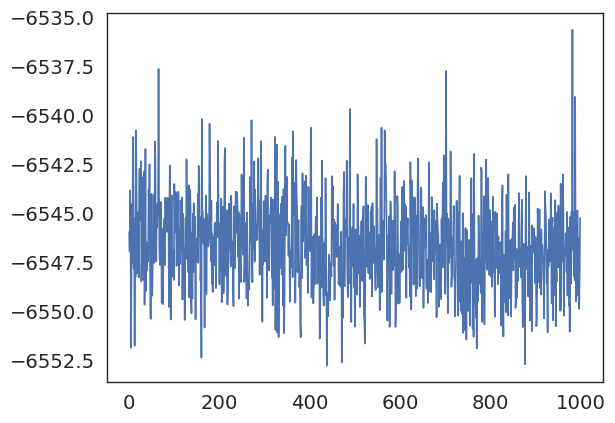

In [7]:
bmr_reg.tau0 = 1e-2
svi_res, smpls = bmr_reg.bmr(
    'multivariate', 
    num_steps=20_000, 
    num_particles=16, 
    num_samples=100, 
    progress_bar=True, 
    opt_kwargs={'learning_rate': 1e-4},
)
plt.plot(svi_res.losses[-1000:])
print(jnp.nanmedian(svi_res.losses[-1000:]))

rng_key, _rng_key = random.split(rng_key)
zipped_smpl, fraction = compression2(_rng_key, len(bmr_reg.layers), smpls, cuttoff=0)

out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
print(out['lpd'], out['acc'], out['nll'], fraction)

In [8]:
rng_key, _rng_key = random.split(rng_key)
zipped_smpl, fraction = compression2(_rng_key, len(bmr_reg.layers), smpls, cuttoff=1.)

out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
print(out['lpd'], out['acc'], out['nll'], fraction)

-23025.853515625 0.099999994 2.3025854 0.9985221


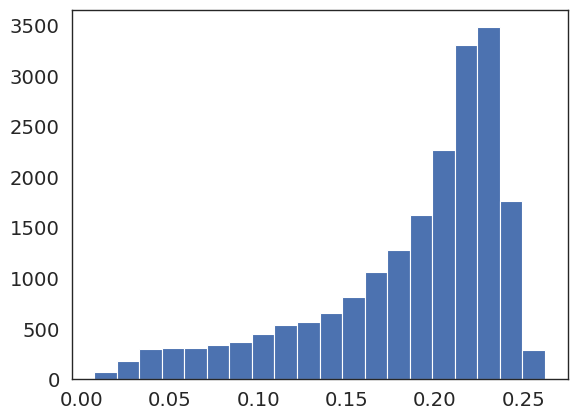

In [11]:
plt.hist(smpls['layer0.weight.gamma'].flatten(), bins=20);

<Axes: >

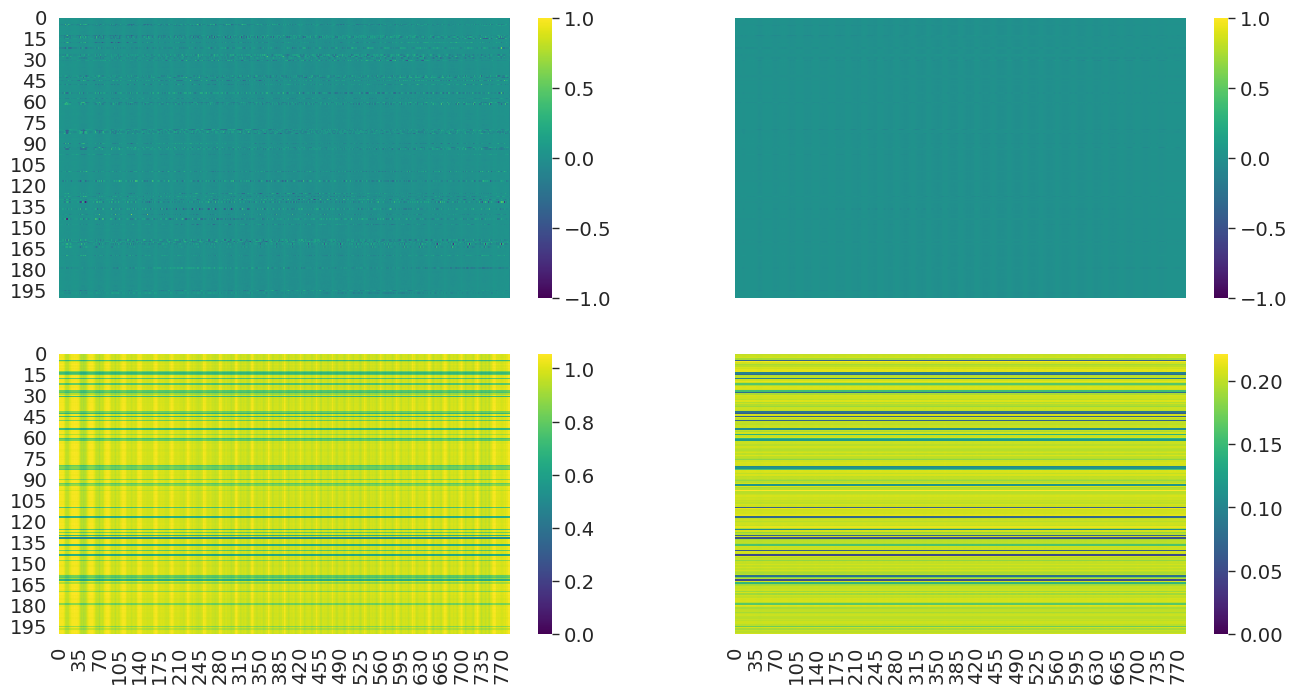

In [10]:
params = bmr_reg.results.params
B = params['layer0.weight.B.T'].T
a = params['layer0.weight.a']
M = params['layer0.weight.loc']
v = jnp.diag(B.T @ B)
j = len(v)
u = jnp.square(a)
i = len(u)
sig = jnp.kron(v, u).reshape(i, j, order='F')

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)

sns.heatmap(M, cmap='viridis', vmin=-1, vmax=1,  ax=axes[0, 0])
sns.heatmap(smpls['layer0.weight.loc'].mean(0), cmap='viridis', vmin=-1, vmax=1, ax=axes[0, 1])

sns.heatmap(sig, cmap='viridis', vmin=0, ax=axes[1, 0])
sns.heatmap(jnp.sqrt(smpls['layer0.weight.scale']**2).mean(0), cmap='viridis', vmin=0, ax=axes[1, 1])

In [14]:
from models import ΔF_mn
sigma_sqr = 1.
f = lambda x: ΔF_mn(M, a, B, x, sigma_sqr)[0]
g = lambda n: ( jnp.ones(i) - nn.one_hot(n, num_classes=i) ) * sigma_sqr + nn.one_hot(n, num_classes=i) * 1e-16
gamma_sqr = vmap(g)(jnp.arange(i))
k = jnp.argmax(vmap(f)(gamma_sqr))
f(g(k))

Array(246.9375, dtype=float32)

In [24]:
sig.min()

Array(0.4748774, dtype=float32)

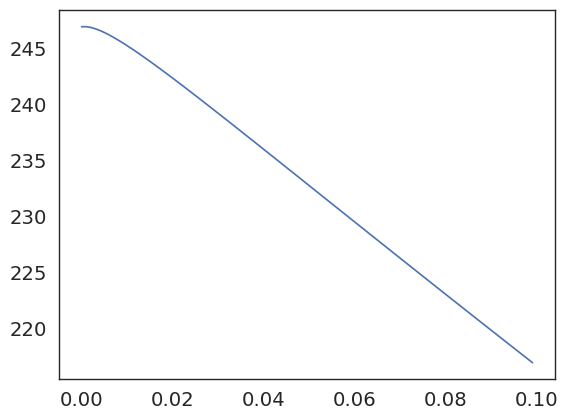

In [19]:
k = jnp.argmax(vmap(f)(gamma_sqr))
h = lambda x: ( jnp.ones(i) - nn.one_hot(k, num_classes=i) ) * sigma_sqr + nn.one_hot(k, num_classes=i) * x

x = jnp.arange(0, 0.1, 1e-3)
df = vmap(f)(vmap(h)(x))
plt.plot(x, df)

1 200


100%|██████████| 80000/80000 [04:58<00:00, 267.60it/s, init loss: 984563.0000, avg. loss [76001-80000]: 108930.0234]


-3992.715087890625 0.86679995 0.36626947
-6486.42724609375 0.7704 0.6807066 0.96392053


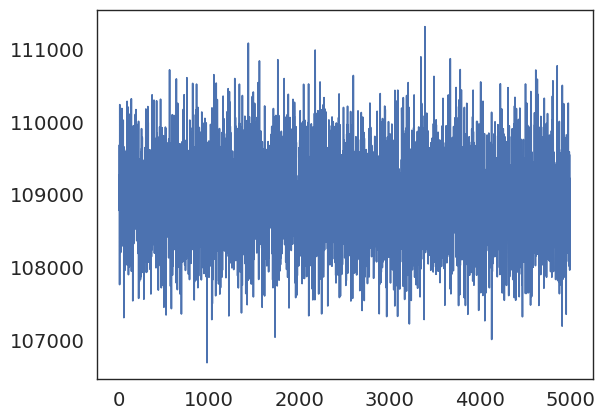

In [6]:
for nh in num_hn[-1:]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        posterior='ktied',
        gamma0=opts['gamma0'],
        rank=5
    )
    
    bmr_reg.fit(
        train_ds['label'], 
        num_steps=opts['num_steps'], 
        num_particles=opts['num_particles'], 
        progress_bar=True, 
        opt_kwargs={'learning_rate': opts['learning_rate']}
    )
    plt.plot(bmr_reg.results.losses[-5_000:])

    bmr_reg.samples.pop('obs')    
    bmr_reg.set_input(X_test)

    out = test_smpl(_rng_key, bmr_reg.model, bmr_reg.samples, test_ds['label'])
    print(out['lpd'], out['acc'], out['nll'])

    zipped_smpl, fraction = compression(len(bmr_reg.layers), bmr_reg.samples, cuttoff=3.)
    out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
    print(out['lpd'], out['acc'], out['nll'], fraction)
    
    del bmr_reg

1 200


100%|██████████| 80000/80000 [04:56<00:00, 269.98it/s, init loss: 541393.6875, avg. loss [76001-80000]: 75277.9219]


-3608.57666015625 0.884 0.3258418
-4418.8837890625 0.83019996 0.46309295 0.9408779


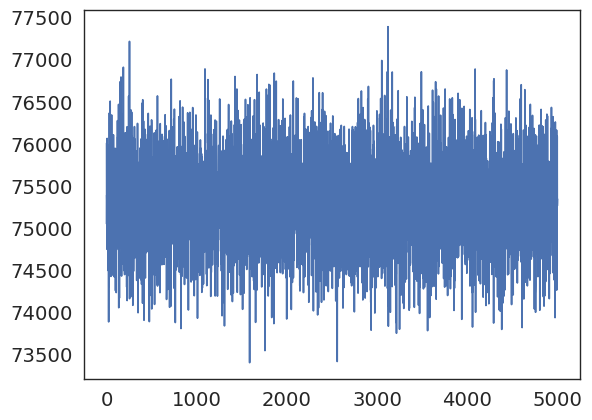

In [7]:
for nh in num_hn[-1:]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        posterior='normal',
        gamma0=opts['gamma0']
    )
    
    bmr_reg.fit(
        train_ds['label'], 
        num_steps=opts['num_steps'], 
        num_particles=opts['num_particles'], 
        progress_bar=True, 
        opt_kwargs={'learning_rate': opts['learning_rate']}
    )    
    plt.plot(bmr_reg.results.losses[-5_000:])

    bmr_reg.samples.pop('obs')    
    bmr_reg.set_input(X_test)

    out = test_smpl(_rng_key, bmr_reg.model, bmr_reg.samples, test_ds['label'])
    print(out['lpd'], out['acc'], out['nll'])

    zipped_smpl, fraction = compression(len(bmr_reg.layers), bmr_reg.samples, cuttoff=1.)
    out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
    print(out['lpd'], out['acc'], out['nll'], fraction)

100%|██████████| 20000/20000 [00:24<00:00, 823.63it/s, init loss: -95774.7578, avg. loss [19001-20000]: -109546.3281] 


-109546.45
-22960.826171875 0.099999994 2.2938569 0.0


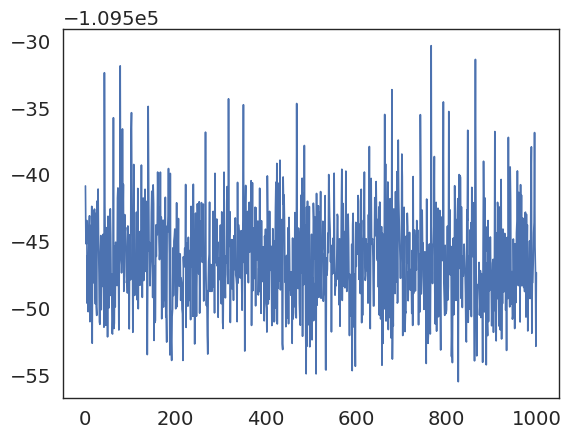

In [12]:
bmr_reg.reduced = True
bmr_reg.tau0 = 1e-2
svi_res, smpls = bmr_reg.bmr(
    'multivariate', 
    num_steps=20_000, 
    num_particles=16, 
    num_samples=100, 
    progress_bar=True, 
    opt_kwargs={'learning_rate': 1e-3},
)
plt.plot(svi_res.losses[-1000:])
print(jnp.nanmedian(svi_res.losses[-1000:]))

rng_key, _rng_key = random.split(rng_key)
zipped_smpl, fraction = compression(len(bmr_reg.layers), smpls, cuttoff=0)

out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
print(out['lpd'], out['acc'], out['nll'], fraction)

100%|██████████| 20000/20000 [01:06<00:00, 302.97it/s, init loss: 923029.0000, avg. loss [19001-20000]: -57543.3359]


-57541.914
-22959.8046875 0.099999994 2.2937937 0.0


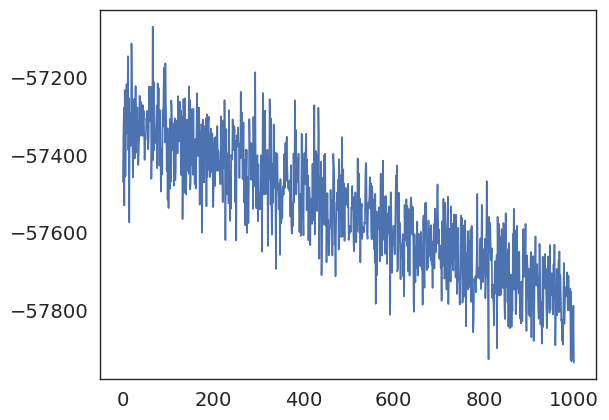

In [9]:
bmr_reg.tau0 = 1e-4
svi_res, smpls = bmr_reg.bmr(
    'mean-field', 
    num_steps=20_000, 
    num_particles=16, 
    num_samples=100, 
    progress_bar=True, 
    opt_kwargs={'learning_rate': 1e-4},
)
plt.plot(svi_res.losses[-1000:])
print(jnp.nanmedian(svi_res.losses[-1000:]))

rng_key, _rng_key = random.split(rng_key)
zipped_smpl, fraction = compression(len(bmr_reg.layers), smpls, cuttoff=0)

out = test_smpl(_rng_key, bmr_reg.model, zipped_smpl, test_ds['label'])
print(out['lpd'], out['acc'], out['nll'], fraction)

In [ ]:
import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular
from jax import jit, grad

from jax.config import config
# config.update("jax_enable_x64", True)

FMIN = jnp.finfo(jnp.float16).min
def safe_log(x):
    y = jnp.where(x > 0., x, 1.)
    return jnp.where(x > 0., jnp.log(y), FMIN)

@jit
def ΔF_mn1(M, a, B, gamma_sqr, sigma_sqr):
    # Delta F for matrix normal posterior
    # vec(AXB) = (B^T \otimes A) vec(X)
    i, j = M.shape

    Z_trans = solve_triangular(B, M.T, trans=1) / a
    Z = Z_trans.T

    df = - jnp.trace(Z_trans @ Z) / 2
    df = df + j * i * jnp.log(sigma_sqr) / 2 # - j * jnp.log(gamma_sqr).sum() / 2

    V = B.T @ B
    u = jnp.square(a)
    _g = 1 - gamma_sqr/sigma_sqr

    lam, Q = jnp.linalg.eigh(V)
    Q_inv = Q.T
    inv_mat = 1 / ( jnp.kron(jnp.ones(j), gamma_sqr) + jnp.kron(lam, u * _g))
    D = inv_mat.reshape(i, j, order='F')

    t_M = gamma_sqr[:, None] * ( ( D * ( M @ Q ) ) @ Q_inv )
    t_S = jnp.sqrt( (u * gamma_sqr)[:, None] * (D @ (Q_inv * (Q_inv @ V ))) ) # diagonal of the covariance matrix

    df += safe_log(inv_mat).sum() / 2

    t_Z_trans = solve_triangular(B, t_M.T, trans=1) / a
    df += jnp.trace(t_Z_trans @ Z ) / 2

    return df, t_M, t_S

@jit
def ΔF_mn2(M, a, B, gamma_sqr, sigma_sqr):
    # vec(AXB) = (B^T \otimes A) vec(X)
    i, j = M.shape

    Z = solve_triangular(B, M.T, trans=1) / a
    Z_trans = Z.T

    df = - jnp.trace(Z @ Z_trans) / 2
    df = df - j * jnp.log(gamma_sqr).sum() / 2 + j * i * jnp.log(sigma_sqr) / 2

    V = B.T @ B
    u = jnp.square(a)
    g_inv = 1/gamma_sqr - 1/sigma_sqr

    lam, Q = jnp.linalg.eigh(V)
    inv_mat = 1 / ( 1 + jnp.kron(lam, u * g_inv))

    D = inv_mat.reshape(i, j, order='F')
    t_M = ( D * jnp.dot( M, Q ) ) @ Q.T
    
    df += jnp.log(inv_mat).sum() / 2

    t_Z_trans = solve_triangular(B, t_M.T, trans=1) / a
    df += jnp.trace(t_Z_trans @ Z_trans ) / 2

    return df

@jit
def ΔF_mv(mu, P, gamma_sqr, sigma_sqr):

    _mu = P @ mu
    df = - jnp.inner(mu, _mu) / 2

    M = jnp.diag(gamma_sqr) @ P + jnp.diag(1 - gamma_sqr/sigma_sqr)

    _, logdet = jnp.linalg.slogdet(M)
    df -= logdet / 2

    _, logdet = jnp.linalg.slogdet(P)
    df += logdet / 2

    df += jnp.sum(jnp.log(sigma_sqr))
    
    H = jnp.eye(len(mu)) + jnp.linalg.solve(P, jnp.diag(1/gamma_sqr - 1/sigma_sqr))
    t_P = P @ H
    t_mu = jnp.linalg.solve(H, mu)

    df += jnp.inner(t_mu, _mu) / 2
    
    return df, t_mu, t_P

@jit
def ΔF_mf(mu, pi, gamma_sqr, sigma_sqr):

    _mu = pi * mu
    df = - jnp.inner(mu, _mu) / 2

    M = gamma_sqr * (pi - 1/sigma_sqr) + 1

    df -= jnp.log(M).sum() / 2

    df += (jnp.log(pi) + jnp.log(sigma_sqr)).sum() / 2

    t_sig_sqr = gamma_sqr / M
    _mu = pi * mu
    t_mu = t_sig_sqr * _mu
    
    df += jnp.inner(t_mu, _mu) / 2
    
    return df, t_mu, jnp.sqrt(t_sig_sqr)

In [ ]:
from jax import random
from numpyro.distributions import LKJCholesky
key = random.PRNGKey(0)
i = 5
j = 10
M = random.normal(key, (i, j))
a = random.gamma(key, 2., shape=(i,))
b = random.gamma(key, 2., shape=(j,))
A = jnp.diag(a)
U = jnp.diag( a ** 2)
B = LKJCholesky(j).sample(key).T
# B = jnp.diag(b)
V = B.T @ B
gamma_sqr = jnp.ones(i)/10
sigma_sqr = 1.

In [ ]:
print(ΔF_mn1(M, a, B, gamma_sqr, sigma_sqr)[0])
%timeit ΔF_mn1(M, a, B, gamma_sqr, sigma_sqr)[0]

grad_DF = jit(grad( lambda x:  ΔF_mn1(M, a, B, x, sigma_sqr)[0]))
%timeit grad_DF(gamma_sqr)

-34.93873193375177
1.11 ms ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.03 ms ± 270 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
print(ΔF_mn2(M, a, B, gamma_sqr, sigma_sqr))
%timeit ΔF_mn2(M, a, B, gamma_sqr, sigma_sqr)

grad_DF = jit(grad( lambda x:  ΔF_mn2(M, a, B, x, sigma_sqr)))
%timeit grad_DF(gamma_sqr)

-34.93873193375177
1.06 ms ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.01 ms ± 266 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
P = jnp.kron( jnp.linalg.inv(B.T @ B), jnp.diag(1/a ** 2) )
print(ΔF_mv(M.reshape(-1, order='F'), P, jnp.kron(jnp.ones(j), gamma_sqr), jnp.ones(i*j) * sigma_sqr)[0])
%timeit ΔF_mv(M.reshape(-1, order='F'), P, jnp.kron(jnp.ones(j), gamma_sqr), jnp.ones(i*j) * sigma_sqr)[0]

grad_DF = jit(grad( lambda x:  ΔF_mv(M.reshape(-1, order='F'), P, jnp.kron(jnp.ones(j), x), jnp.ones(i*j) * sigma_sqr)[0]))
print(grad_DF(gamma_sqr))
%timeit grad_DF(gamma_sqr)

-34.93873193375185
1.58 ms ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
[ 25.19580372 111.78824155   3.71440408  19.79809939   6.03346923]
1.16 ms ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
pi = jnp.kron( jnp.diag( jnp.linalg.inv(B.T @ B) ), 1/a ** 2)
g_sqr = jnp.kron(jnp.ones(j), gamma_sqr)
mu = M.reshape(-1, order='F')
print( ΔF_mf(mu, pi, g_sqr, sigma_sqr)[0])
%timeit ΔF_mf(mu, pi, g_sqr, sigma_sqr)[0]

grad_DF = jit(grad( lambda x:  ΔF_mf(mu, pi, jnp.kron(jnp.ones(j), x), sigma_sqr)[0]))
%timeit grad_DF(gamma_sqr)


-39.74306534713891
117 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
58.4 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
